In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
import math
import seaborn as sns

In [2]:
jogos = pd.read_csv("spi_matches.csv")
Santos = jogos[np.logical_or(jogos['team1'] == 'Santos', jogos['team2'] == 'Santos')]
jogos_Santos = Santos[['date', 'team1', 'team2', 'score1', 'score2', 'prob1', 'prob2', 'importance1', 'importance2', 'spi1', 'spi2']]

In [3]:
for label, row in jogos_Santos.iterrows() :
    print(str(row["date"]) + " : " + str(row["team1"]) + " " + str(row["score1"])[0] + "x"  + str(row["score2"])[0] + " " + str(row["team2"]))
    if(row['team1'] == "Santos") :
        jogos_Santos.loc[label, "gols_santos"] = row['score1']
        jogos_Santos.loc[label, "gols_adv"] = row['score2']
        jogos_Santos.loc[label, "local"] = 0.0
        jogos_Santos.loc[label, "prob_Santos"] = row['prob1']
        jogos_Santos.loc[label, "spi_Santos"] = row['spi1']
        if(math.isnan(row['importance1'])) :
            jogos_Santos.loc[label, "importance_Santos"] = 25.0
        else : 
            jogos_Santos.loc[label, "importance_Santos"] = row['importance1']
    else :
        jogos_Santos.loc[label, "gols_santos"] = row['score2']
        jogos_Santos.loc[label, "gols_adv"] = row['score1']
        jogos_Santos.loc[label, "local"] = 1.0
        jogos_Santos.loc[label, "prob_Santos"] = row['prob2']
        jogos_Santos.loc[label, "spi_Santos"] = row['spi2']
        if(math.isnan(row['importance2'])) :
            jogos_Santos.loc[label, "importance_Santos"] = 25.0
        else : 
            jogos_Santos.loc[label, "importance_Santos"] = row['importance2']

2017-05-14 : Fluminense 3x2 Santos


C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2017-05-20 : Santos 1x0 Coritiba
2017-05-28 : Santos 0x1 Cruzeiro
2017-06-03 : Corinthians 2x0 Santos
2017-06-07 : Santos 1x0 Botafogo
2017-06-11 : Atlético Paranaense 0x2 Santos
2017-06-14 : Santos 1x0 Palmeiras
2017-06-17 : Santos 0x0 Ponte Preta
2017-06-21 : Vítoria 0x2 Santos
2017-06-24 : Santos 0x1 Sport Recife
2017-07-01 : Atlético Goianiense 1x1 Santos
2017-07-09 : Santos 3x2 São Paulo
2017-07-12 : Atletico Mineiro 0x1 Santos
2017-07-16 : Vasco da Gama 0x0 Santos
2017-07-19 : Santos 1x0 Chapecoense AF
2017-07-23 : Santos 3x0 Bahía
2017-07-30 : Grêmio 1x1 Santos
2017-08-02 : Santos 3x2 Flamengo
2017-08-06 : Avaí 0x0 Santos
2017-08-14 : Santos 0x0 Fluminense
2017-08-20 : Coritiba 0x0 Santos
2017-08-27 : Cruzeiro 1x1 Santos
2017-09-10 : Santos 2x0 Corinthians
2017-09-16 : Botafogo 2x0 Santos
2017-09-23 : Santos 1x0 Atlético Paranaense
2017-09-30 : Palmeiras 0x1 Santos
2017-10-12 : Ponte Preta 1x1 Santos
2017-10-16 : Santos 2x2 Vítoria
2017-10-19 : Sport Recife 1x1 Santos
2017-10-22

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


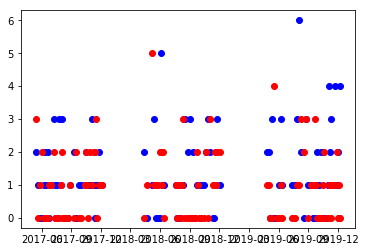

<Figure size 432x288 with 0 Axes>

In [4]:
jogos_Santos["datetimeobj"] = jogos_Santos["date"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))

plt.plot_date(x=jogos_Santos['datetimeobj'], y=jogos_Santos['gols_santos'], xdate = True, ydate = False, color = 'blue')
plt.plot_date(x=jogos_Santos['datetimeobj'], y=jogos_Santos['gols_adv'], xdate = True, ydate = False, color = 'red')
plt.show()
plt.clf()

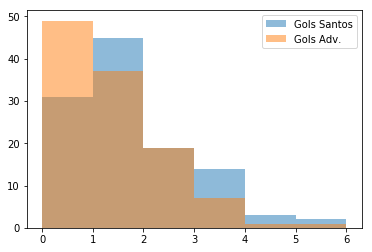

<Figure size 432x288 with 0 Axes>

In [5]:
plt.hist(jogos_Santos['gols_santos'], bins = range(7), alpha=0.5, label='Gols Santos')
plt.hist(jogos_Santos['gols_adv'], bins = range(7), alpha=0.5, label='Gols Adv.')
plt.legend(loc='upper right')
plt.xticks(range(7))
plt.show()
plt.clf()

# Treinando kNeighbors para prever numero de gols

In [13]:
Santos_predict = jogos_Santos[['gols_santos','prob_Santos', 'importance_Santos', 'spi_Santos', 'local']]

X = Santos_predict.drop('gols_santos', axis=1).values
y = Santos_predict['gols_santos'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_test,y_test)
print("Predicted scores = ") 
print(knn.predict(X_test))
print("Precision of model = ") 
print(knn.score(X_test, y_test))


Predicted scores = 
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
Precision of model = 
0.5652173913043478


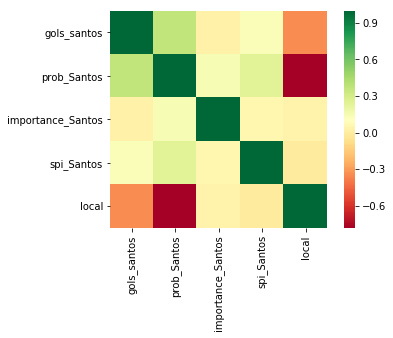

In [8]:
ax = sns.heatmap(Santos_predict.corr(), square=True, cmap='RdYlGn')
plt.show()